In [1]:
# Load libraries

# Data Manipulation
import pandas as pd
import numpy as np
# Data Visualization
import matplotlib.pyplot as plt
# Pipeline
from sklearn.pipeline import Pipeline
# Custom transformers
from custom_transformers import Cleaner, StopWordsRemover, Lemmatizer
# TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Modeling
from sklearn.tree._classes import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
# Split into train and test sets
from sklearn.model_selection import train_test_split
# Evaluation
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score, confusion_matrix
# Save model
import pickle

# Download the Spanish model
# import stanza
# stanza.download("es")

In [2]:
# Load the dataset
dataset = pd.read_csv("./../datasets/dataset_labeled_v2.csv")

# Load stop words
with open("stop_words.txt", "r") as f:
    stop_words = f.read().splitlines()

print(stop_words)
display(dataset.head())
print(dataset.info())

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '_', 'a', 'actualmente', 'acuerdo', 'adelante', 'ademas', 'ademÃ¡s', 'adrede', 'afirmÃ³', 'agregÃ³', 'ahi', 'ahora', 'ahÃ\xad', 'al', 'algo', 'alguna', 'algunas', 'alguno', 'algunos', 'algÃºn', 'alli', 'allÃ\xad', 'alrededor', 'ambos', 'ampleamos', 'antano', 'antaÃ±o', 'ante', 'anterior', 'antes', 'apenas', 'aproximadamente', 'aquel', 'aquella', 'aquellas', 'aquello', 'aquellos', 'aqui', 'aquÃ©l', 'aquÃ©lla', 'aquÃ©llas', 'aquÃ©llos', 'aquÃ\xad', 'arriba', 'arribaabajo', 'asegurÃ³', 'asi', 'asÃ\xad', 'atras', 'aun', 'aunque', 'ayer', 'aÃ±adiÃ³', 'aÃºn', 'b', 'bajo', 'bastante', 'bien', 'breve', 'buen', 'buena', 'buenas', 'bueno', 'buenos', 'c', 'cada', 'casi', 'cerca', 'cierta', 'ciertas', 'cierto', 'ciertos', 'cinco', 'claro', 'comentÃ³', 'como', 'con', 'conmigo', 'conocer', 'conseguimos', 'conseguir', 'considera', 'considerÃ³', 'consigo', 'consigue', 'consiguen', 'consigues', 'contigo', 'contra', 'cosas', 'creo', 'cual', 'cuales', 'c

,id,date,text,url,location,label
0,1476701687070998535,2021-12-30 23:48:12+00:00,#ATENCIÓN ⚠️ Dos presuntos delincuentes fuero...,https://twitter.com/noticiasru593/status/14767...,['Samborondón'],robo
1,1476682498826452992,2021-12-30 22:31:57+00:00,Y si los hackean @PoliciaEcuador y me terminan...,https://twitter.com/lujacome/status/1476682498...,[],robo
2,1476675906903191552,2021-12-30 22:05:46+00:00,@EPattoA @PoliciaEcuador Les encanta quedar as...,https://twitter.com/Rengel_A_G/status/14766759...,[],robo
3,1476672423076499456,2021-12-30 21:51:55+00:00,🙌📢 CONSULTA CONECTADOS | El asalto del año fue...,https://twitter.com/conectados_ec/status/14766...,['Santiago'],robo
4,1476669177104588806,2021-12-30 21:39:01+00:00,@EPattoA @PoliciaEcuador 14 años robando Que q...,https://twitter.com/cesar197449/status/1476669...,[],robo


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598 entries, 0 to 597
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        598 non-null    int64 
 1   date      598 non-null    object
 2   text      598 non-null    object
 3   url       598 non-null    object
 4   location  598 non-null    object
 5   label     598 non-null    object
dtypes: int64(1), object(5)
memory usage: 28.2+ KB
None


In [3]:
# display(raw_df.head(5))
# pd.set_option("display.max_colwidth", None)
# display(raw_df[raw_df.duplicated(subset=["id"], keep=False)].sort_values(by="id"))

In [4]:
pipeline = Pipeline(steps=[
    ("cleaner", Cleaner()),
    ("stop_words_remover", StopWordsRemover(stop_words=stop_words)),
    ("lemmatizer", Lemmatizer()),
    ("tfidf", TfidfVectorizer()),
])

In [5]:
def calculate_metrics(y_test, prediction):
    print("\n Reporte de Clasificación:")
    print(classification_report(y_test, prediction))

    # Confusion Matrix:
    classes = y_test.unique()
    classes.sort()
    cm = confusion_matrix(y_test, prediction, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    print('Matriz de Confusión:')
    disp.plot()
    plt.show()

    # Calculamos el número de instancias clasificadas correctamente
    correct = np.sum(np.diag(cm))
    print('\nInstancias clasificadas correctamente:\n\n', correct)

    # Calculamos el número de instancias clasificadas incorrectamente
    incorrect = cm.sum() - correct
    print('\nInstancias clasificadas incorrectamente:\n\n', incorrect)

    # Calculamos FP, FN, TP y TN para cada clase operando con la matriz de confusión
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    # Calculamos el TP Rate (Recall) para cada clase
    TPR = TP/(TP + FN)
    print('\nTP Rate (Recall) por clase:\n\n', TPR)

    # Calculamos el FP Rate para cada clase
    FPR = FP/(FP + TN)
    print('\nFP Rate por clase:\n\n', FPR)

    # Calculamos la exactitud del modelo
    accuracy = accuracy_score(y_test, prediction)
    print('\nExactitud:\n\n', accuracy)

In [6]:
def train_model(pipeline, classifier, X_train, y_train):
    if pipeline.steps[-1][0] == "classifier":
        pipeline.steps.pop()
    pipeline.steps.append(["classifier", classifier])
    model = pipeline.fit(X=X_train['text'], y=y_train)
    # print(model.steps[-2][1].get_feature_names_out().shape)
    # print(model.steps[-2][1].get_feature_names_out())
    return model

In [7]:
def get_predictions(X_test, model):
    predictions = model.predict(X_test['text'])
    return predictions

In [8]:
def save_model(model, path):
    with open(path, "wb") as f:  # wb = write binary
        pickle.dump(model, f)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(dataset, dataset['label'], test_size=0.2, random_state=42)

In [10]:
decision_tree = DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    class_weight=None,
    ccp_alpha=0.0,
    monotonic_cst=None
)

linear_svc = LinearSVC(
    penalty='l2',
    loss='squared_hinge',
    dual='auto',
    tol=0.0001,
    C=1.0,
    multi_class='ovr',
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    verbose=0,
    random_state=None,
    max_iter=1000
)

random_forest = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
    monotonic_cst=None
)

classifiers = {
    "Decision Tree": decision_tree,
    "Linear SVC": linear_svc,
    "Random Forest": random_forest,
}

Decision Tree


d:\GitHub\tfm\.venv\lib\site-packages\spacy\language.py:1037: UserWarning: Due to multiword token expansion or an alignment issue, the original text has been replaced by space-separated expanded tokens.
  doc = self._ensure_doc(text)
d:\GitHub\tfm\.venv\lib\site-packages\spacy\language.py:1037: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['cárcel', 'latacunga', 'crear', 'cárcel', 'bandas', 'narco', 'joven', 'delincuente', 'rehabilitar', 'se', 'reintegrar', 'sociedad', 'repetir', 'recuerda', 'robando', 'haciendo', 'se', 'jefe', 'barrio', 'falta', 'oportunidades', 'vemos', 'terminar', 'oportunidad', 'jóvenes']
Entities: []
  doc = self._ensure_doc(text)
d:\GitHub\tfm\.venv\lib\site-packages\spacy\language.py:1037: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by


 Reporte de Clasificación:
                precision    recall  f1-score   support

     asesinato       0.75      0.95      0.84        19
     extorsion       0.87      0.93      0.90        14
no relacionado       1.00      0.91      0.95        23
          robo       0.90      0.79      0.84        24
     secuestro       0.89      0.89      0.89        19
    terrorismo       1.00      0.95      0.98        21

      accuracy                           0.90       120
     macro avg       0.90      0.90      0.90       120
  weighted avg       0.91      0.90      0.90       120

Matriz de Confusión:


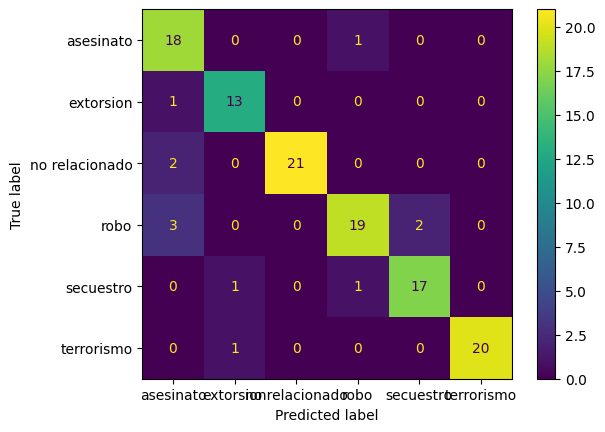


Instancias clasificadas correctamente:

 108

Instancias clasificadas incorrectamente:

 12

TP Rate (Recall) por clase:

 [0.94736842 0.92857143 0.91304348 0.79166667 0.89473684 0.95238095]

FP Rate por clase:

 [0.05940594 0.01886792 0.         0.02083333 0.01980198 0.        ]

Exactitud:

 0.9
Linear SVC


d:\GitHub\tfm\.venv\lib\site-packages\spacy\language.py:1037: UserWarning: Due to multiword token expansion or an alignment issue, the original text has been replaced by space-separated expanded tokens.
  doc = self._ensure_doc(text)
d:\GitHub\tfm\.venv\lib\site-packages\spacy\language.py:1037: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['cárcel', 'latacunga', 'crear', 'cárcel', 'bandas', 'narco', 'joven', 'delincuente', 'rehabilitar', 'se', 'reintegrar', 'sociedad', 'repetir', 'recuerda', 'robando', 'haciendo', 'se', 'jefe', 'barrio', 'falta', 'oportunidades', 'vemos', 'terminar', 'oportunidad', 'jóvenes']
Entities: []
  doc = self._ensure_doc(text)
d:\GitHub\tfm\.venv\lib\site-packages\spacy\language.py:1037: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by


 Reporte de Clasificación:
                precision    recall  f1-score   support

     asesinato       0.74      0.89      0.81        19
     extorsion       0.81      0.93      0.87        14
no relacionado       0.95      0.87      0.91        23
          robo       0.86      0.79      0.83        24
     secuestro       0.94      0.84      0.89        19
    terrorismo       1.00      1.00      1.00        21

      accuracy                           0.88       120
     macro avg       0.88      0.89      0.88       120
  weighted avg       0.89      0.88      0.88       120

Matriz de Confusión:


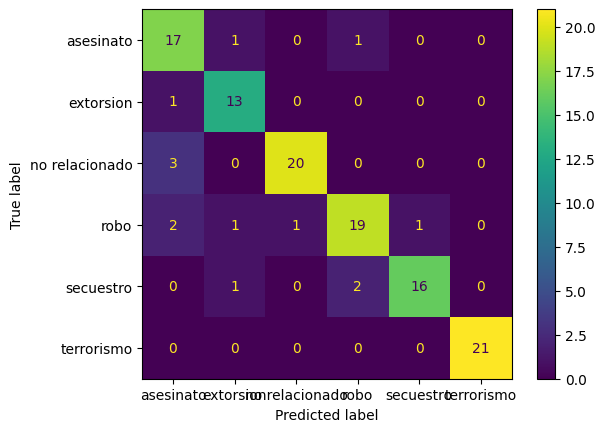


Instancias clasificadas correctamente:

 106

Instancias clasificadas incorrectamente:

 14

TP Rate (Recall) por clase:

 [0.89473684 0.92857143 0.86956522 0.79166667 0.84210526 1.        ]

FP Rate por clase:

 [0.05940594 0.02830189 0.01030928 0.03125    0.00990099 0.        ]

Exactitud:

 0.8833333333333333
Random Forest


d:\GitHub\tfm\.venv\lib\site-packages\spacy\language.py:1037: UserWarning: Due to multiword token expansion or an alignment issue, the original text has been replaced by space-separated expanded tokens.
  doc = self._ensure_doc(text)
d:\GitHub\tfm\.venv\lib\site-packages\spacy\language.py:1037: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['cárcel', 'latacunga', 'crear', 'cárcel', 'bandas', 'narco', 'joven', 'delincuente', 'rehabilitar', 'se', 'reintegrar', 'sociedad', 'repetir', 'recuerda', 'robando', 'haciendo', 'se', 'jefe', 'barrio', 'falta', 'oportunidades', 'vemos', 'terminar', 'oportunidad', 'jóvenes']
Entities: []
  doc = self._ensure_doc(text)
d:\GitHub\tfm\.venv\lib\site-packages\spacy\language.py:1037: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by


 Reporte de Clasificación:
                precision    recall  f1-score   support

     asesinato       0.75      0.95      0.84        19
     extorsion       1.00      0.93      0.96        14
no relacionado       0.91      0.91      0.91        23
          robo       0.95      0.75      0.84        24
     secuestro       0.95      1.00      0.97        19
    terrorismo       1.00      1.00      1.00        21

      accuracy                           0.92       120
     macro avg       0.93      0.92      0.92       120
  weighted avg       0.93      0.92      0.92       120

Matriz de Confusión:


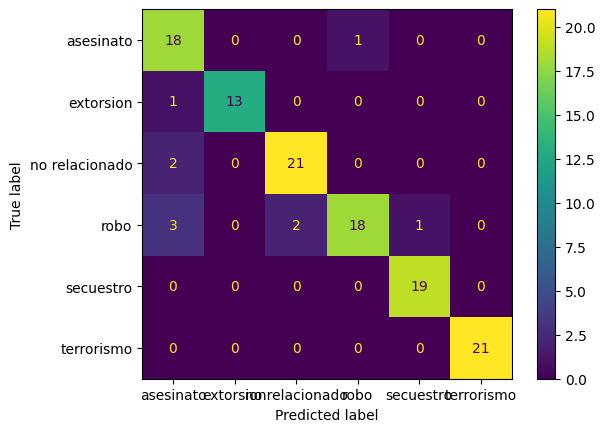


Instancias clasificadas correctamente:

 110

Instancias clasificadas incorrectamente:

 10

TP Rate (Recall) por clase:

 [0.94736842 0.92857143 0.91304348 0.75       1.         1.        ]

FP Rate por clase:

 [0.05940594 0.         0.02061856 0.01041667 0.00990099 0.        ]

Exactitud:

 0.9166666666666666


In [11]:
for name, classifier in classifiers.items():
    print(name)
    model = train_model(pipeline, classifier, X_train, y_train)
    predictions = get_predictions(X_test, model)
    calculate_metrics(y_test, predictions)
    name = name.lower().replace(" ", "_")
    path = f"./../models/model_{name}.pkl"
    save_model(model, path)

In [12]:
# import pickle

# # Load the model
# with open("./../models/model.pkl", "rb") as f:  # rb = read binary
#     model_loaded = pickle.load(f)

# prediction = model_loaded.predict(dataset['text'])
# dataset['prediction'] = prediction
# dataset